# PPCA

$\mathcal{N}(z|0, \mu, \sigma^2)$

In [1]:
# from plot import *
from sampling import *

import numpy as np
import scipy.linalg as sl
from pathlib import Path


def import_data() -> np.array:
    fname = "data.txt"
    f = open(fname,'r')
    data = []
    for line in f:
        s = line.split()
        data.append([float(s[0]),float(s[1])])
    f.close()

    return np.array(data)


class ppca:

    def __init__(self, X=None, num_components=1):

        self.q = num_components
        self.mu = None
        self.sigma2 = None
        self.W = None

        if X is not None:
            self.fit(X)


    def fit(self, X):

        mu_ml = np.mean(X, axis=0)

        data_cov = np.cov(X, rowvar=False)

        # Variance
        lambdas, eigenvecs = np.linalg.eig(data_cov)
        idx = lambdas.argsort()[::-1]   
        lambdas = lambdas[idx]
        eigenvecs = - eigenvecs[:,idx]
        print(eigenvecs)
        print(eigenvecs @ np.diag(lambdas) @ np.transpose(eigenvecs))

        var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])
        print(f"Var ML: {var_ml}")

        # Weight matrix
        uq = eigenvecs[:,:q]
        print("uq:")
        print(uq)

        lambdaq = np.diag(lambdas[:q])

        weight_ml = uq * np.sqrt(lambdaq - var_ml * np.eye(q))


    def predict(self, Xtest):

        q = self.q
        m = np.transpose(weight_ml) @ weight_ml + var_ml * np.eye(q)

        # rescale

        cov = var_ml * np.linalg.inv(m)
        act_hidden = []
        for data_visible in Xtest:
            mean = np.linalg.inv(m) @ np.transpose(weight_ml) @ (data_visible - mu_ml)
            sample = np.random.multivariate_normal(mean,cov,size=1)
            act_hidden.append(sample[0])
        
        return np.array(act_hidden)


---

Data mean:
[2662.32666667 3019.5       ]
Data cov:
[[24828.9596868    102.74161074]
 [  102.74161074   218.01006711]]


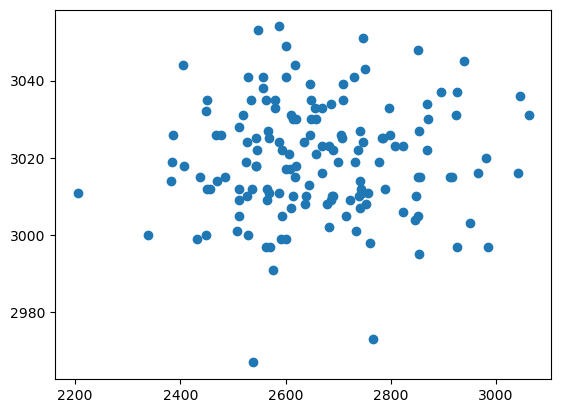

In [6]:
# --------------------------------------------

# Import data

#
import matplotlib.pyplot as plt

data = import_data()

# figs = {}
# figs["data"] = plot_hist_2d(data, "Data")

d = data.shape[1]
plt.plot(data[:, 0], data[:, 1], 'o')
print("\n---\n")

mu_ml = np.mean(data,axis=0)
print("Data mean:")
print(mu_ml)

data_cov = np.cov(data,rowvar=False)
print("Data cov:")
print(data_cov)


In [9]:
# -------------------------------------------------------------------

# Max. likelihood

#

print("\n---\n")

# No hidden variables < no visibles = d
q = 1

# Variance
lambdas, eigenvecs = np.linalg.eig(data_cov)
idx = lambdas.argsort()[::-1]   
lambdas = lambdas[idx]
eigenvecs = - eigenvecs[:,idx]

var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])
print("Var ML:")
print(var_ml)

# Weight matrix
uq = eigenvecs[:,:q]
print("uq:")
print(uq)

lambdaq = np.diag(lambdas[:q])
print("lambdaq")
print(lambdaq)

weight_ml = uq * np.sqrt(lambdaq - var_ml * np.eye(q))
print("Weight matrix ML:")
print(weight_ml)


---

[[-0.99999129  0.00417452]
 [-0.00417452 -0.99999129]]
[[24828.9596868    102.74161074]
 [  102.74161074   218.01006711]]
Var ML:
217.58116636932957
uq:
[[-0.99999129]
 [-0.00417452]]
lambdaq
[[24829.38858755]]
Weight matrix ML:
[[-156.88014062]
 [  -0.65490514]]


In [11]:
print(np.load(r"C:\Users\johnk\Documents\git\DeepMagnetics\models\model3.npy").shape)

(200, 200, 200)
